In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from functools import reduce

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
print(sc.__version__)
sc.settings.n_jobs=12

1.4.5.post1


In [3]:
prefix = '/data/codec/production.run/'

In [49]:
path = prefix + '/adts/pkls/concat.adts.norm.log.pkl'

# with open(path,'wb') as file:
#     pkl.dump(concat_adts, file)
    
with open(path,'rb') as file:
    concat_adts = pkl.load(file)

In [50]:
path = prefix + 'mrna/obs/concat.obs.csv'

obs = pd.read_csv(path, index_col=0)

In [51]:
concat_adts['adata'].obs = concat_adts['adata'].obs.join(obs,lsuffix='-adts', rsuffix='-mrna')
assert all(concat_adts['adata'].obs['batch-adts'].values.astype(int) == concat_adts['adata'].obs['batch-mrna'].values.astype(int))
concat_adts['adata'].obs.drop(columns='batch-adts', inplace=True)
concat_adts['adata'].obs.rename(columns={'batch-mrna':'batch'}, inplace=True)
concat_adts['adata'].obs['batch'] = concat_adts['adata'].obs['batch'].astype('category')

computing PCA with n_comps = 100
    reducing number of computed PCs to 95 as dim of data is only 96
    finished (0:00:01)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


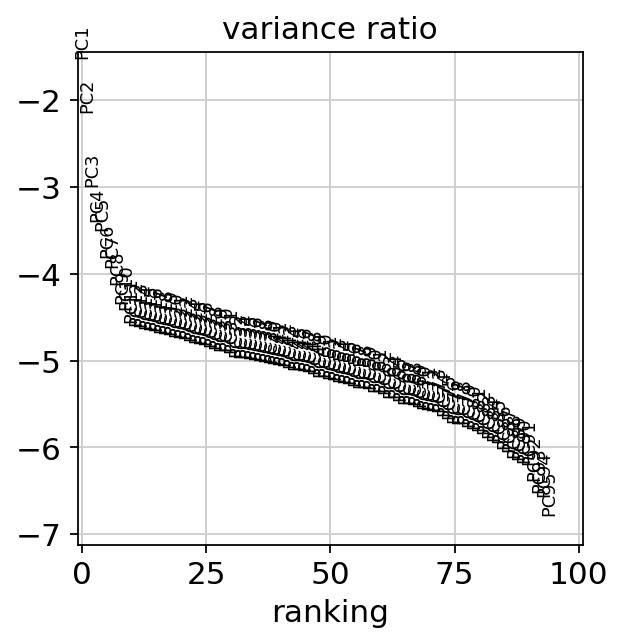

In [53]:
warnings.filterwarnings('ignore')
sc.pp.pca(concat_adts['adata'], n_comps=100)
sc.pl.pca_variance_ratio(concat_adts['adata'],log=True, n_pcs=100)
warnings.filterwarnings('default')

In [54]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat_adts['adata'], n_neighbors=15) # use .X because all the surface markers we're looking at are probably pretty important
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 95
    computed neighbors (0:01:53)
    computed connectivities (0:00:09)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:02:03)


In [56]:
sc.tl.umap(concat_adts['adata'])

computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:32)


In [64]:
sc.tl.leiden(concat_adts['adata'], resolution=1)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:52)


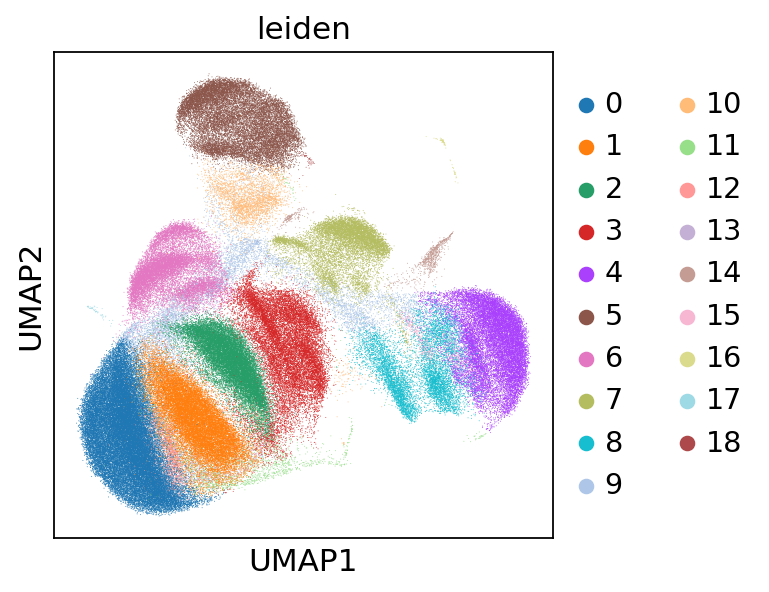

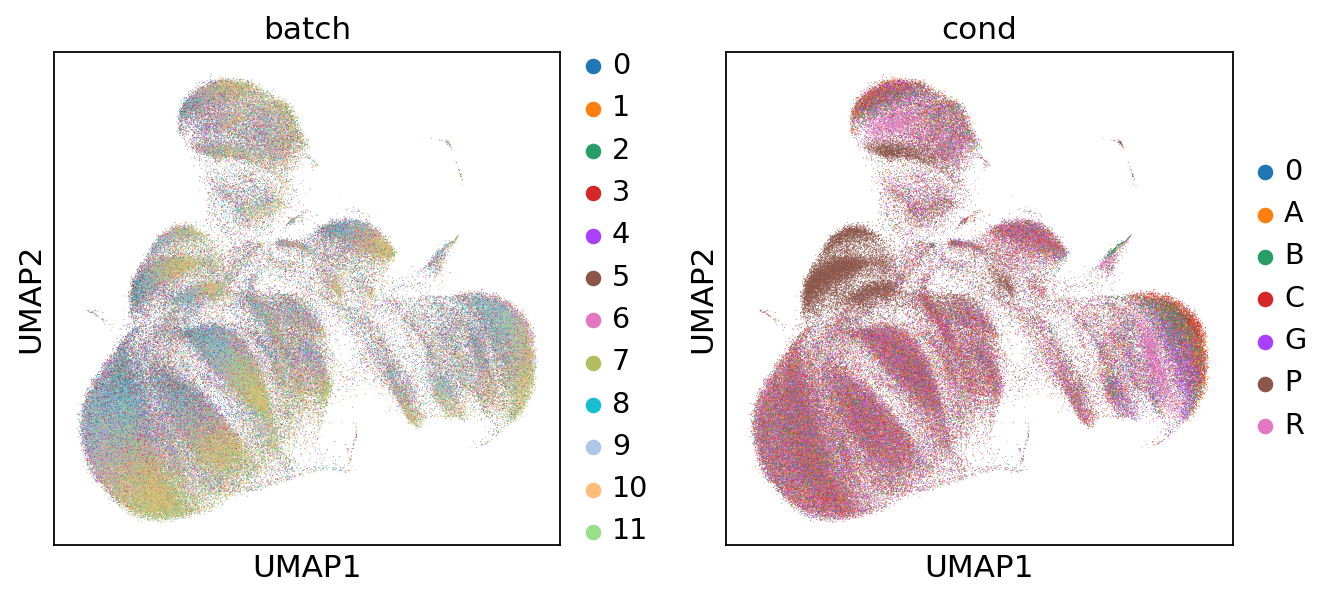

In [68]:
sc.pl.umap(concat_adts['adata'], color=['leiden'])
sc.pl.umap(concat_adts['adata'], color=['batch', 'cond'])

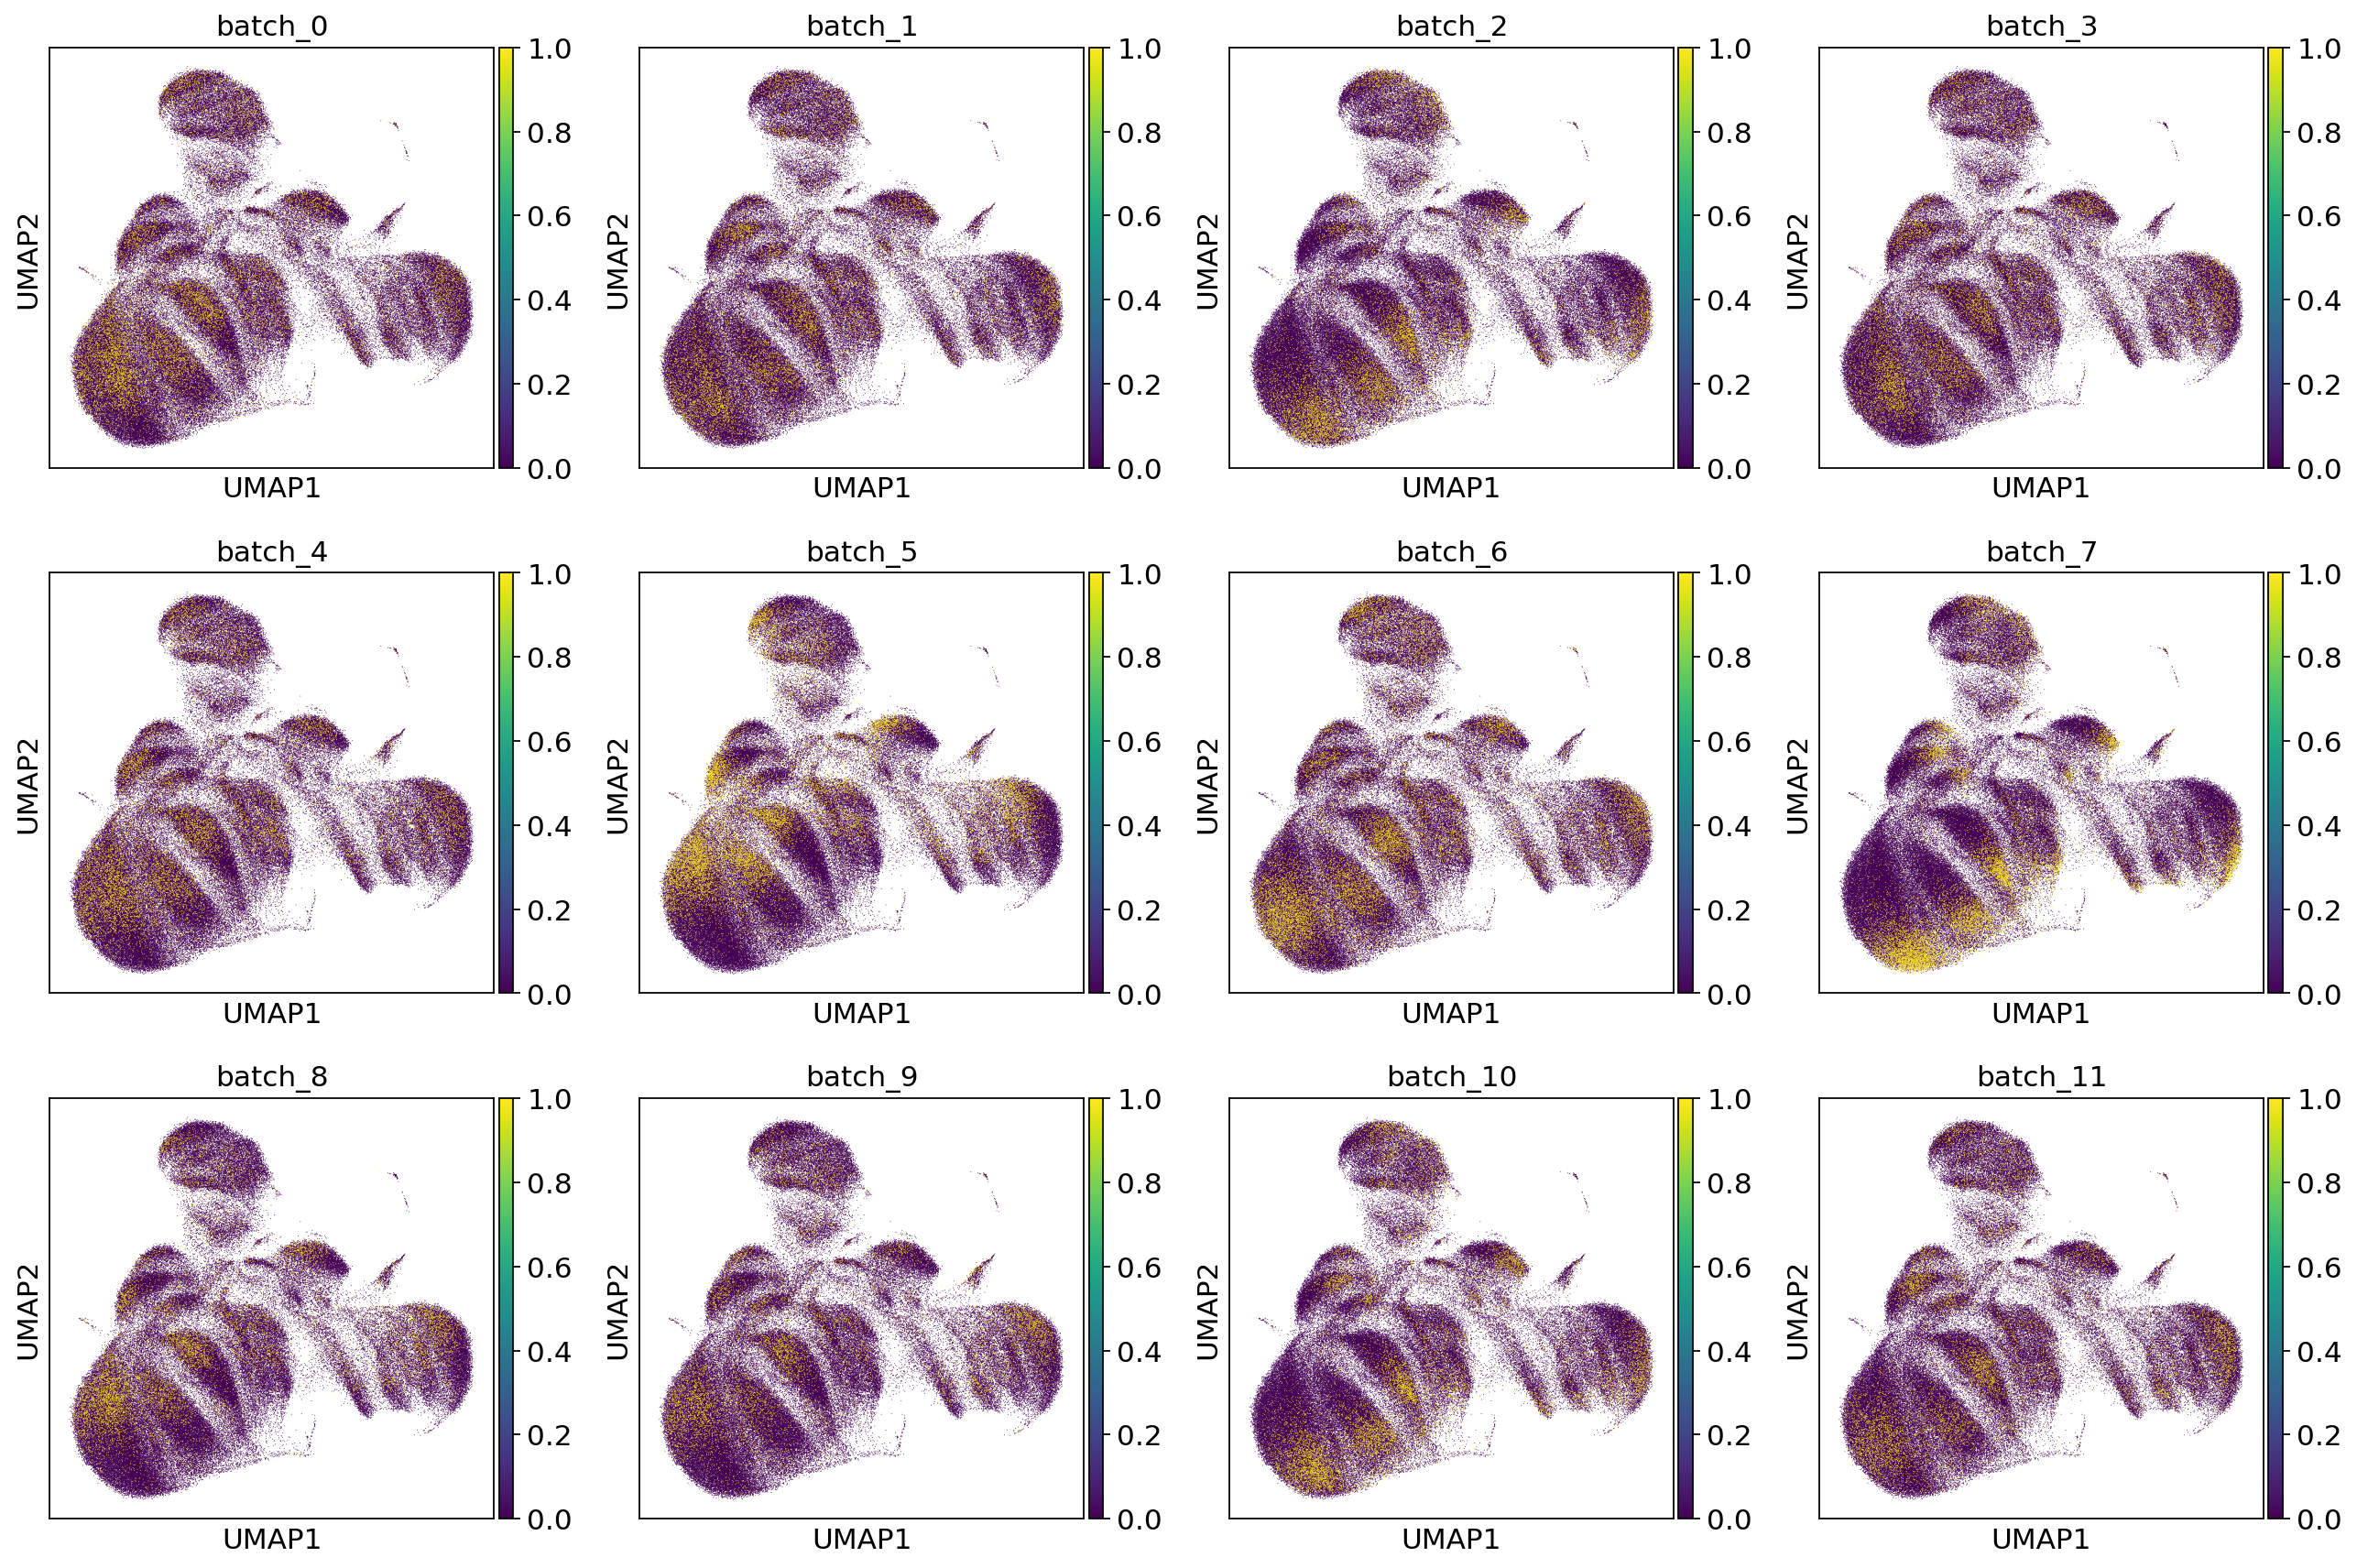

In [67]:
batches = concat_adts['adata'].obs['batch'].unique() # get a list of the batches

# make a new column in the `.obs` for each batch that is of dtype `int` and that just takes on values of 0 and 1 so that it gets plotted as a continuous variable instead of a categorical one
for batch in batches:
    concat_adts['adata'].obs['batch_%s' % batch] = (concat_adts['adata'].obs['batch'] == batch).astype(int)
    
# plot now with sort_order=True, which should apply to this new continuous variable
sc.pl.umap(concat_adts['adata'], color=['batch_%s' % i for i in batches],sort_order=True, ncols=4)

In [66]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat_adts['adata'], groupby='leiden', n_genes=20)
warnings.filterwarnings('default')
# sc.pl.rank_genes_groups(concat_adts['adata'], ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [77]:
for clust in concat_adts['adata'].obs['leiden'].dtype._categories:
    print(clust + ": " + str(concat_adts['adata'].uns['rank_genes_groups']['names'][clust][:5]))

0: ['CD4|CD4' 'TCRab|TRA_TRB' 'CD3|CD3E' 'CD27|CD27' 'CD62L|SELL']
1: ['CD4|CD4' 'CD45RO|PTPRC' 'CD28|CD28' 'CD95|FAS' 'CD5|CD5']
2: ['CD8|CD8A' 'CD45RA|PTPRC' 'CD27|CD27' 'CD7|CD7' 'CD197|CCR7']
3: ['CD11a|ITGAL' 'CD8|CD8A' 'CD81|CD81' 'CD49d|ITGA4' 'CD2|CD2']
4: ['CD11c|ITGAX' 'CD18|ITGB2' 'CD32|FCGR2A_B_C' 'CD49E|ITGA5' 'CD54|ICAM1']
5: ['CD185|CXCR5' 'CD21|CR2' 'HLA-ABC|HLA-A_B_C' 'IgD|IGHD' 'CD24|CD24']
6: ['CD69|CD69' 'CD98|SLC3A2' 'CD154|CD40LG' 'CD2|CD2' 'CD27|CD27']
7: ['CD16|FCGR3A' 'CD94|KLRD1' 'CD56|NCAM1' 'CD11a|ITGAL' 'CD335|NCR1']
8: ['CD11c|ITGAX' 'CD18|ITGB2' 'CD86|CD86' 'CD33|CD33' 'CD49E|ITGA5']
9: ['B7-H4|VTCN1' 'CD235a_b|GYPA_GYPB' 'CD194|CCR4' 'CD117|KIT'
 'IL-21R|IL21R']
10: ['CD185|CXCR5' 'CD21|CR2' 'HLA-ABC|HLA-A_B_C' 'IgD|IGHD' 'CD45RA|PTPRC']
11: ['CD61|ITGB3' 'CD49b|ITGA2' 'CD226|CD226' 'CD9|CD9' 'CD29|ITGB1']
12: ['CD4|CD4' 'CD3|CD3E' 'TCRab|TRA_TRB' 'CD27|CD27' 'CD5|CD5']
13: ['CD94|KLRD1' 'CD4|CD4' 'CD7|CD7' 'CD11a|ITGAL' 'CD38|CD38']
14: ['CD123|IL3RA' '

In [73]:
concat_adts['adata'].uns['rank_genes_groups']

params
scores
names
logfoldchanges
pvals
pvals_adj


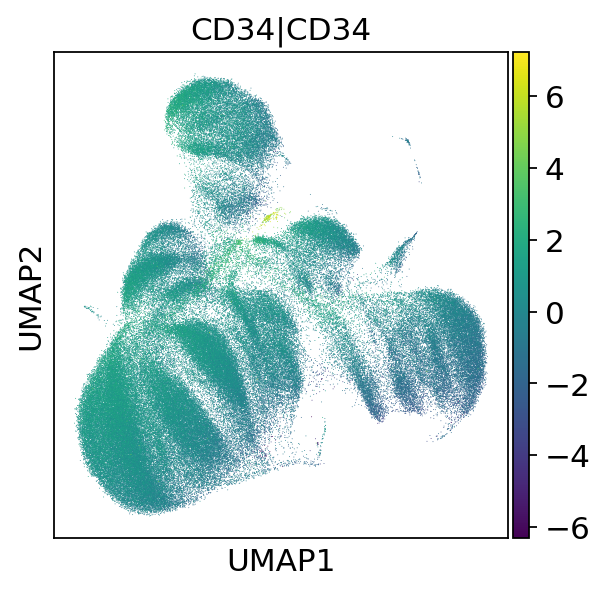

In [78]:
sc.pl.umap(concat_adts['adata'], color=['CD34|CD34'])